In [1]:
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
import os
from tensorflow import keras
from keras.models import load_model

C:\Users\Admin\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\Admin\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\Admin\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:519: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\Admin\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:520: FutureWarning: Passi

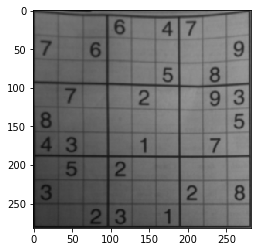

In [2]:
img_test = cv2.imread('data/sudoku_3.jpg')
img_test = cv2.resize(img_test,(282,282))
plt.imshow(img_test, cmap='gray')
plt.show()

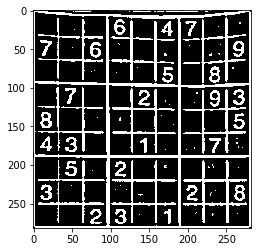

In [3]:
def preprocess(img):
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img = cv2.GaussianBlur(img, (5,5), 1)
    img = cv2.adaptiveThreshold(img, maxValue=255, adaptiveMethod=1, thresholdType=1, blockSize=11, C=2)
    return img

pp_img = preprocess(img_test)
plt.imshow(pp_img, cmap='gray')
plt.show()

In [4]:
def find_countour(img, pp):
    img_copy = img.copy()
    contours = cv2.findContours(pp, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    img_contour = cv2.drawContours(img_copy, contours[1], -1, (0, 255, 0), 3)
    return img_contour, contours

img_cnt, cnt = find_countour(img_test, pp_img)

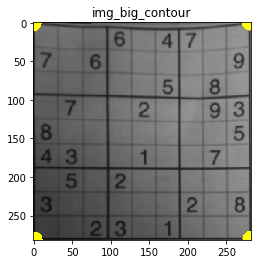

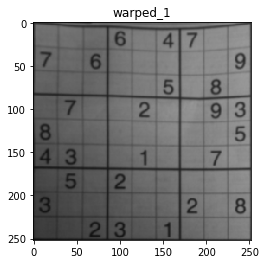

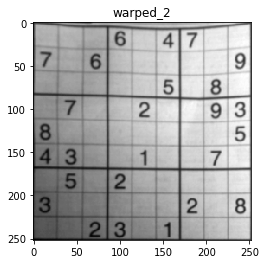

In [5]:
def bigContour(contours):
    big = np.array([])
    max_area = 0
    for i in contours:
        area = cv2.contourArea(i)
        if area > 50: #if too small, will find noise
            perimeter = cv2.arcLength(i, True)
            approx = cv2.approxPolyDP(i, 0.02*perimeter, True)
            if area > max_area and len(approx)==4: #checking of rect/square
                big = approx
                max_area = area
    return big, max_area

# order of the 4 points should be the same always. reorder() ensures this
def reorder(points):
    points = points.reshape((4,2))
    points_new = np.zeros((4,1,2), dtype=np.int32)
    add = points.sum(1)
    points_new[0] = points[np.argmin(add)]
    points_new[3] =  points[np.argmax(add)]
    diff = np.diff(points, axis=1)
    points_new[1] = points[np.argmin(diff)]
    points_new[2] = points[np.argmax(diff)]
    return points_new

def function(img, contours):
    img_big_contour = img.copy()
    big, max_area = bigContour(contours[1])
    if big.size!=0:
        big = reorder(big)
        img_big_contour = cv2.drawContours(img_big_contour, big, -1, (255,255,0), 20) #draw the biggest contour
        plt.title('img_big_contour')
        plt.imshow(img_big_contour, cmap='gray')
        plt.show()
        # preapres points for warp
        pts1 = np.float32(big) 
        pts2 = np.float32([[0,0], [252,0], [0,252], [252, 252]])
        matrix = cv2.getPerspectiveTransform(pts1, pts2)
        warped_img = cv2.warpPerspective(img, matrix, (252, 252))
        plt.title('warped_1')
        plt.imshow(warped_img, cmap='gray')
        plt.show()
        warped_img = cv2.cvtColor(warped_img, cv2.COLOR_RGB2GRAY)
        plt.title('warped_2')
        plt.imshow(warped_img, cmap='gray')
        plt.show()
        return warped_img
    
warped = function(img_test, cnt)

In [6]:
def postprocess(image):
    for i,img in enumerate(image):
        mean = np.mean(img)
        std = np.std(img)
        image[i] = (img-mean)/std
    return image
# post_img = postprocess(warped)

In [7]:
def split_boxes(image):
    rows = np.vsplit(image, 9)
    boxes = []
    for r in rows:
        cols = np.hsplit(r, 9)
        for box in cols:
            
            boxes.append(box)
    return boxes

In [10]:
def getbox(img):
    boxes = split_boxes(img)
    for i in range(len(boxes)):
        for j in range(len(boxes[i])):
            boxes[i][j][0]=0
            boxes[i][j][-1]=0      

    nums = np.array([1 if np.sum(boxes[i].flatten())/(255*81)>0.7 else 0 for i in range(len(boxes))])

    return np.array(boxes), nums

boxes, nums = getbox(warped)

In [12]:
def predict(boxes):
    model = load_model('model.h5')
    boxes = np.reshape(boxes, (-1,28,28,1))
    predicted_numbers = model.predict_classes(boxes)
#     predicted_numbers = []
#     predicted_proba = []
#     for b in boxes:
#         b = np.reshape(b,(1,28,28))
#         predicted_numbers.append(model.predict_classes(b))
#         predicted_proba.append(model.predict_proba(b))
    return predicted_numbers
pred = predict(boxes)

In [13]:
pred

array([5, 5, 5, 1, 1, 1, 1, 1, 1, 1, 5, 1, 5, 1, 1, 1, 1, 1, 5, 5, 5, 5,
       1, 1, 1, 1, 1, 5, 1, 5, 5, 1, 1, 1, 1, 8, 1, 5, 5, 5, 1, 1, 1, 1,
       0, 1, 1, 5, 5, 1, 1, 1, 1, 1, 5, 1, 5, 1, 5, 5, 1, 1, 1, 1, 5, 5,
       5, 5, 5, 1, 1, 0, 5, 5, 1, 1, 5, 1, 5, 5, 1], dtype=int64)

In [10]:
cam = cv2.VideoCapture(0)
  
try:
      
    # creating a folder named data
    if not os.path.exists('data'):
        os.makedirs('data')
  # if not created then raise error
except OSError:
    print ('Error: Creating directory of data')
  # frame


while(True):
    
    # reading from frame
    ret,frame = cam.read()
#     plt.imshow(frame)
#     plt.show()
    pp_img = preprocess(frame)
    img_cnt, cnt = find_countour(frame, pp_img)
    warped = function(frame, cnt)
#     post_img = postprocess(warped)
    boxes, nums = getbox(warped)
    pred,proba = predict(boxes)
    break
    if cv2.waitKey(1) & 0xFF==ord('q'):
        break

cam.release()
cv2.destroyAllWindows()

ValueError: vsplit only works on arrays of 2 or more dimensions

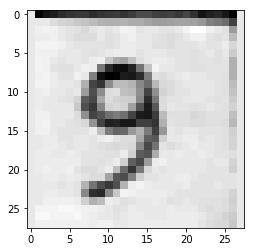

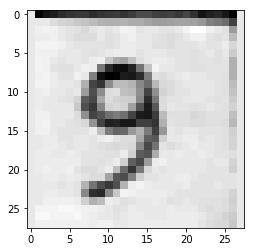

array([1], dtype=int64)

In [95]:
i=8
temp = boxes[i]
a,b = np.unique(temp, return_counts=True)
temp[temp <1] = a[np.argmax(b)]
plt.imshow(boxes[i], cmap='gray')
plt.show()
plt.imshow(temp,  cmap='gray')
plt.show()
temp = np.reshape(temp,(1,28,28,1))
model.predict_classes(temp)
# predict(temp)

In [100]:
630*20+51193/30*10

29664.333333333336

In [47]:
np.reshape(boxes[0][boxes[0]!=0],(1,28,28))

ValueError: cannot reshape array of size 728 into shape (1,28,28)

In [38]:
np.reshape(predict(boxes)[0],(9,9))

array([[1, 1, 5, 5, 1, 5, 1, 5, 1],
       [5, 1, 5, 5, 5, 8, 1, 5, 1],
       [1, 5, 5, 1, 5, 5, 5, 5, 5],
       [5, 1, 5, 1, 5, 5, 5, 1, 5],
       [1, 1, 1, 5, 5, 5, 1, 5, 1],
       [5, 1, 5, 5, 5, 5, 5, 1, 5],
       [5, 5, 5, 5, 5, 1, 5, 5, 1],
       [1, 5, 1, 5, 1, 5, 5, 1, 5],
       [1, 5, 1, 5, 5, 1, 5, 1, 5]], dtype=int64)

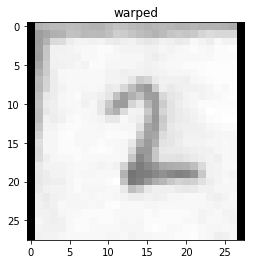

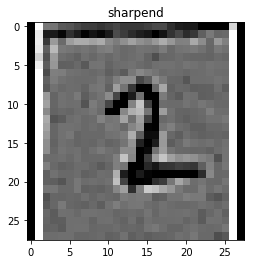

ValueError: cannot reshape array of size 28 into shape (28,28,1)

In [35]:
# temp = np.reshape([pred[i] if nums[i]>0 else 0 for i in range(81)], (9,9))
# print(temp)
for item in boxes:
    plt.title('warped')
    plt.imshow(item,cmap='gray')
    plt.show()
#     item = item/255
    i,p = noise_red(item)
#     pred = predict(item)
    print(p)
    print('------------------------')

In [ ]:
temp = np.zeros(81)
for i, item in enumerate(nums):
    if item==1:
        temp[i] = pred[i]
temp = np.reshape(temp, (9,9))
print(temp)

In [ ]:
plt.imshow(warped)
plt.show()

In [ ]:
# for c in cnt[1]:
#     x,y,w,h = cv2.boundingRect(c)
#     if w>100 and h>50:
#         break
# cropped = img_cnt[y:y+h, x:x+w]

In [ ]:
# np.sum(boxes[10].flatten())/(255*81)

In [ ]:
# crop = cv2.resize(cropped, (252,252))
# temp = cv2.cvtColor(postprocess(crop), cv2.COLOR_BGR2GRAY)
# plt.imshow(warped)
# plt.show()
plt.imshow(postprocess(warped))
plt.show()


In [ ]:
# cropped = cv2.resize(cropped, (282,282))
# pp_img = preprocess(cropped)
# img_cnt, cnt = find_countour(frame, pp_img)
# warped = function(cropped, cnt)
# post_img = postprocess(cropped)
boxes, nums = getbox(warped)
# print(nums)
a = predict(np.array(boxes))


print(np.reshape(nums*a, (9,9)))

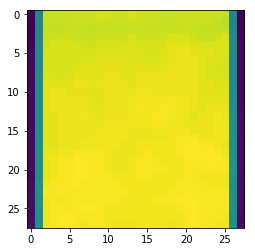

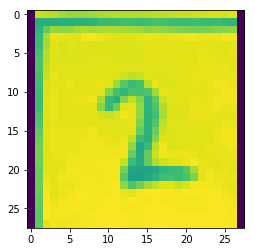

In [46]:

plt.imshow(cv2.GaussianBlur(cv2.medianBlur(boxes[11],3),(3,3),0))
plt.show()
plt.imshow(boxes[0])
plt.show()

In [ ]:
plt.imshow(boxes[4])
plt.show()
np.sum(boxes[4])/(255*81)

In [ ]:
predict([boxes[0]])

In [14]:
def noise_red(img):
#     plt.title('Original')
#     plt.imshow(img)
#     plt.show()
#     kernel = np.ones((5, 5), np.uint8)
#     img = cv2.dilate(img, kernel, iterations = 1)
#     plt.imshow(img)
#     plt.show()    
#     kernel = np.ones((0, 0), np.uint8)
# #     img = cv2.erode(img, kernel, iterations = 1)
# #     plt.imshow(img)
# #     plt.show()
#     img = cv2.morphologyEx(img, cv2.MORPH_CLOSE, kernel)
#     plt.imshow(img)
#     plt.show()
    kernel = np.array([[-1,-1,-1], [-1,9,-1], [-1,-1,-1]])
    img = cv2.filter2D(img, -1, kernel)
#     img = cv2.GaussianBlur(img,(3,3),0)
    plt.title('sharpend')
    plt.imshow(img, cmap='gray')
    plt.show()
    pred = predict(img)
#     print(pred)
    return img,pred
#     print('-----------------------------------------------------------------------')

In [ ]:
noise_red(postprocess(warped))

In [ ]:
arr = [noise_red(boxes[i])[0] if nums[i]>0 else 0 for i in range(len(boxes))]
np.reshape(arr, (9,9))